# Optomechanical system

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm, steadystate
from torchqc.operators import DynamicOperator, Operator
from torchqc.common_matrices import sigmaZ, annihilation, creation, eye
from torchqc.dynamics import lindblad_equation
from torchqc.tensor_product import tensor_product_ops, tensor_product_states

* Start from basis state $\psi_0 \otimes \phi_2$

In [2]:
N = 4 # photon bosonic modes
M = 10 # optomechanical modes
total_dims = N * M
bosonic_basis_states = QuantumState.basis(N)
bosonic_state = bosonic_basis_states[0]

mech_basis_states = QuantumState.basis(M)
mech_state = mech_basis_states[2]

initial_state = tensor_product_states(bosonic_state, mech_state)

* System parameters

In [3]:
T = 50
Dt = 0.01
wc = 10  # cavity frequency
wm = wc  # atom frequency
g = 1.  # coupling strength
η = 2.
k = 1.  # cavity dissipation rate

time = np.arange(0, T, Dt, dtype = np.float32)

* Optomechanical Hamiltonian

In [4]:
a_dagger = creation(N)
a = annihilation(N)

b_dagger = creation(M)
b = annihilation(M)

H_cav = tensor_product_ops(wc * a_dagger * a, eye(M))
H_mec = tensor_product_ops(eye(N), wm  * b_dagger * b)
H_int = g * tensor_product_ops(a_dagger * a, b_dagger + b) + η * tensor_product_ops(a_dagger + a, eye(M))

H = H_cav + H_mec + H_int

In [5]:
hamiltonian = DynamicOperator(total_dims, H, time=time)

* Simulate dynamics with von-Neumann equation

In [6]:
jump_ops = [tensor_product_ops(a, eye(M))]
rates = [k]

rho = get_density_matrix(initial_state)
time_tensor, states = lindblad_equation(rho, hamiltonian, time, Dt, jump_ops, rates)

* Calculate number expectation values

In [7]:
N_op = a_dagger * a
expectation_values_cav = expect_val_dm(states, tensor_product_ops(N_op, eye(M)))

M_op = b_dagger * b
expectation_values_mec = expect_val_dm(states, tensor_product_ops(eye(N), M_op))

* Find steady state

In [8]:
# rho_ss = steadystate(H, jump_ops, rates, method="SVD")
rho_ss = steadystate(H, jump_ops, rates, method="inf", initial_state=rho)

exp_value_cav = expect_val_dm(rho_ss, tensor_product_ops(N_op, eye(M)))
exp_value_mec = expect_val_dm(rho_ss, tensor_product_ops(eye(N), M_op))

print("<n_cav>ss = ", exp_value_cav)
print("<n_mec>ss = ", exp_value_mec)

<n_cav>ss =  tensor(0.0406, dtype=torch.float64)
<n_mec>ss =  tensor(0.0009, dtype=torch.float64)


* Plot results

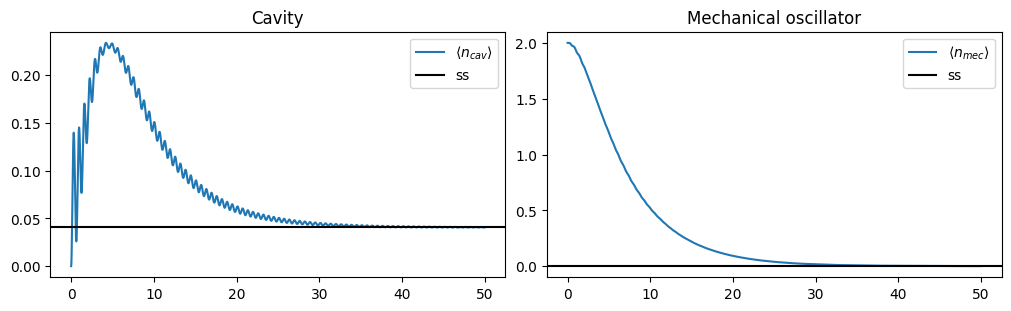

In [9]:
fig, ax = plt.subplots(1, 2, layout='constrained')
fig.set_figwidth(10)
fig.set_figheight(3)

ax1 = ax[0]
ax2 = ax[1]

ax1.plot(time, expectation_values_cav, label=r"$\langle n_{cav} \rangle$")
ax1.set_title("Cavity")
ax1.axhline(y=exp_value_cav, color="k", lw=1.5, label = 'ss')
ax1.legend()

ax2.plot(time, expectation_values_mec, label=r"$\langle n_{mec} \rangle$")
ax2.axhline(y=exp_value_mec, color="k", lw=1.5, label = 'ss')
ax2.set_title("Mechanical oscillator")
ax2.legend()